In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import BayesianRidge, LinearRegression
import warnings

pd.options.display.max_columns = 70
plt.rcParams["figure.figsize"] = (12, 10)
warnings.filterwarnings('ignore')

### Task 1
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [224]:
df = pd.read_csv("../data/owid-covid-data.csv")
print(df.shape)
df.head()

(165180, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [225]:
# filter by country & date
df = df.loc[df["location"] == "Russia"].loc[df["date"] >= "2020-03-03"].reset_index(drop=True)
# replace 0 to 1 in new_cases & fix total_cases
df.loc[df.new_cases == 0, "new_cases"] = 1
df["total_cases"] = np.cumsum(df.new_cases)
# save only needed columns
df = df[["date", "total_cases", "new_cases"]]

In [226]:
train = df.iloc[:50]
test = df.iloc[50:]

In [227]:
train.head()

,date,total_cases,new_cases
0,2020-03-03,1.0,1.0
1,2020-03-04,2.0,1.0
2,2020-03-05,3.0,1.0
3,2020-03-06,12.0,9.0
4,2020-03-07,13.0,1.0


### Task 2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

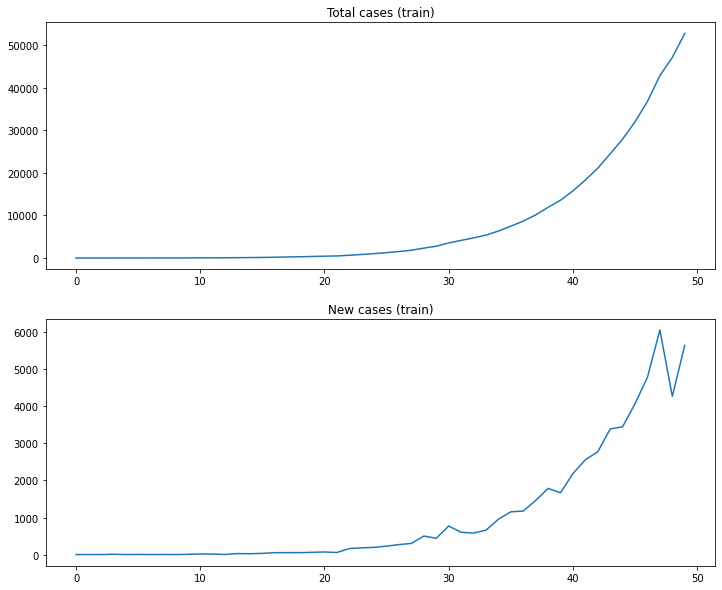

In [228]:
fig, axes = plt.subplots(2, 1)
axes[0].set_title("Total cases (train)")
axes[0].plot(train.total_cases)
axes[1].set_title("New cases (train)")
axes[1].plot(train.new_cases)
plt.show()

#### 2a
Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [335]:
train_days = np.array(train.index)[:, None]
test_days = np.array(test.index)[:, None]

lin_reg = LinearRegression()
lin_reg.fit(train_days, np.log(train.new_cases))
print(f"y' = exp({lin_reg.coef_[0]} * x + {lin_reg.intercept_})")

y' = exp(0.18596309168510522 * x + 0.3206875188996463)


In [336]:
pred_new_cases = np.exp(lin_reg.predict(test_days))
pred_total_cases = np.cumsum(pred_new_cases)

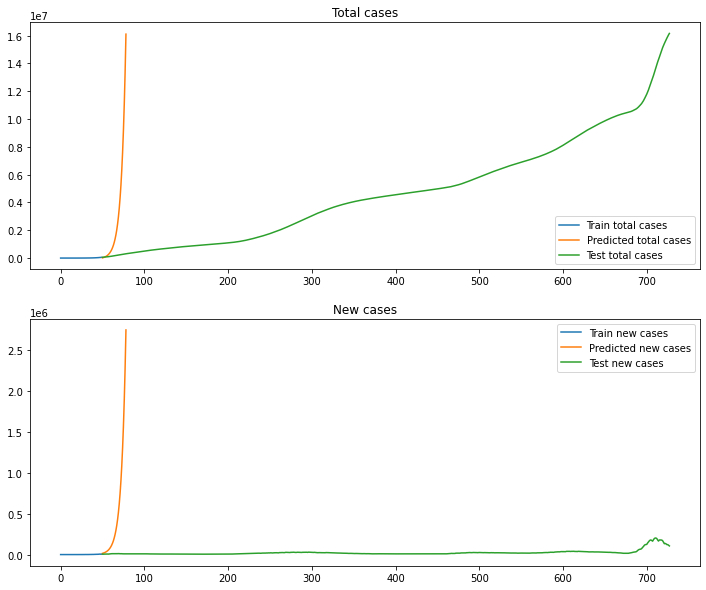

In [337]:
fig, axes = plt.subplots(2, 1)

end = 29
axes[0].set_title("Total cases")
axes[0].plot(train_days, train.total_cases, label="Train total cases")
axes[0].plot(test_days[:end], pred_total_cases[:end], label="Predicted total cases")
axes[0].plot(test_days[:], test.total_cases[:], label="Test total cases")
axes[0].legend()

axes[1].set_title("New cases")
axes[1].plot(train_days, train.new_cases, label="Train new cases")
axes[1].plot(test_days[:end], pred_new_cases[:end], label="Predicted new cases")
axes[1].plot(test_days[:], test.new_cases[:], label="Test new cases")
axes[1].legend()

plt.show()

#### 2b
Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [338]:
def bayesian_update(mu, sigma0, X, y, noise):
    sigma = np.linalg.inv(np.linalg.inv(sigma0) + X.T @ X / noise)   
    mu = sigma @ (np.linalg.inv(sigma0) @ mu + X.T @ y / noise)
    return mu, sigma

new_cases_noise = np.var(np.log(train.new_cases) - lin_reg.predict(train_days))
mu = np.array([lin_reg.coef_[0], lin_reg.intercept_])
sigma = np.eye(len(mu))
x_train = np.hstack((train_days, np.ones((len(train_days), 1))))
print(mu, sigma, new_cases_noise)
mu, sigma = bayesian_update(mu, sigma, x_train, np.log(train.new_cases), new_cases_noise)
mu, sigma

[0.18596309 0.32068752] [[1. 0.]
 [0. 1.]] 0.3553090487811399


(array([0.18596309, 0.32068752]),
 array([[ 3.34420329e-05, -8.13548583e-04],
        [-8.13548583e-04,  2.68473392e-02]]))

#### 2c
Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

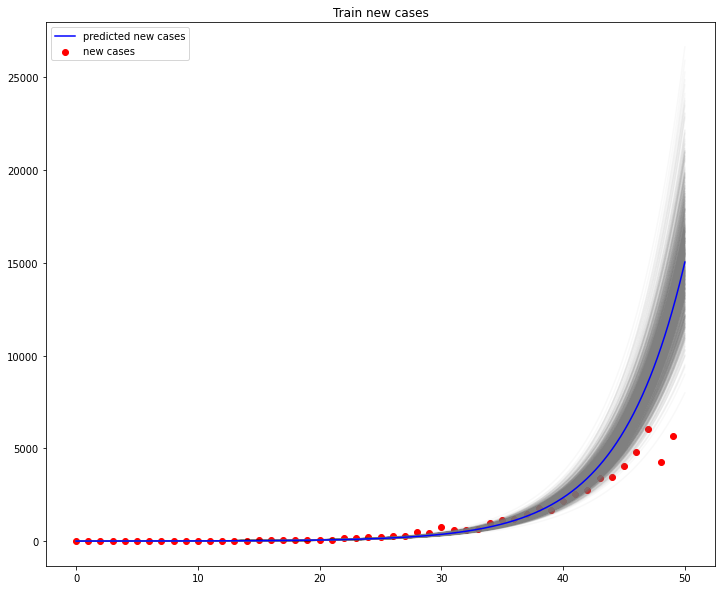

In [346]:
samples = 1000
n = 1000
x_train = np.linspace(0, len(train), samples)[:, None]
weights = np.random.multivariate_normal(mu, sigma, n)
for a, b in weights:
    plt.plot(x_train.flatten(), np.exp(a * x_train + b), color="grey", alpha=.05)
plt.plot(x_train.flatten(), np.exp(lin_reg.predict(x_train)), color="b", label="predicted new cases")
plt.scatter(train.index, train.new_cases, color="r", label="new cases")
plt.legend()
plt.title("Train new cases")
plt.show()

In [341]:
# 1 may
print("1 May", int(pred_total_cases[test[test.date == "2020-05-01"].index[0]]))
# 1 june
print("1 June", int(pred_total_cases[test[test.date == "2020-06-01"].index[0]]))
# 1 sep
print("1 September", int(pred_total_cases[test[test.date == "2020-09-01"].index[0]]))
print("O_O")

1 May 5161011055
1 June 1645834061201
1 September 44315797030703644672
O_O


### Task 3
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана: 
$$ \Phi(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}{e^{\frac{-t^2}{2}}dt} $$
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

#### 3a
Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

$$y'=e^{ax^2+bx+c}$$
$$lny'=ax^2+bx+c$$
y' - predicted new_cases

#### 3b
Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [355]:
train_days2 = np.array([[idx**2, idx] for idx in train.index])
test_days2 = np.array([[idx**2, idx] for idx in test.index])

lin_reg2 = LinearRegression()
lin_reg2.fit(train_days2, np.log(train.new_cases))
print(f"y' = exp({lin_reg2.coef_[0]} * x^2 + {lin_reg2.coef_[1]} * x + {lin_reg2.intercept_})")

y' = exp(-0.001829790616686916 * x^2 + 0.27562283190276404 * x + -0.39659040284162295)


In [356]:
pred_new_cases2 = np.exp(lin_reg2.predict(test_days2))
pred_total_cases2 = np.cumsum(pred_new_cases2)

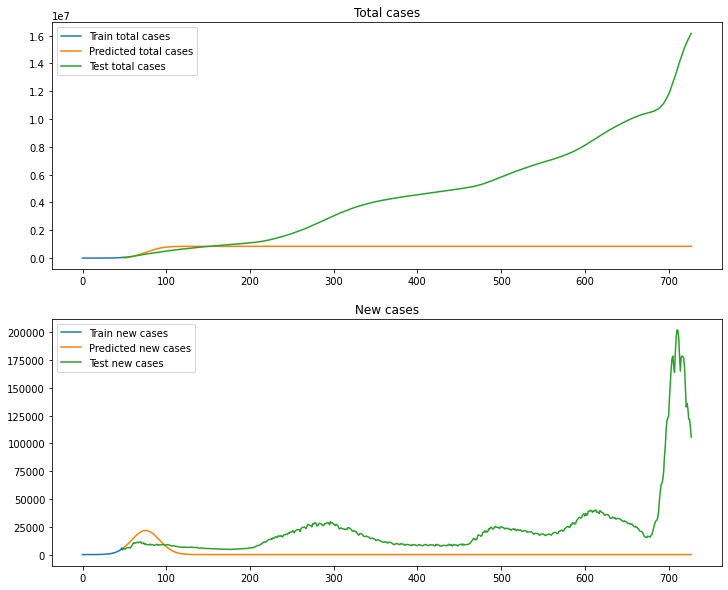

In [359]:
fig, axes = plt.subplots(2, 1)

axes[0].set_title("Total cases")
axes[0].plot(train_days, train.total_cases, label="Train total cases")
axes[0].plot(test_days[:], pred_total_cases2[:end], label="Predicted total cases")
axes[0].plot(test_days[:], test.total_cases[:], label="Test total cases")
axes[0].legend()

axes[1].set_title("New cases")
axes[1].plot(train_days, train.new_cases, label="Train new cases")
axes[1].plot(test_days[:], pred_new_cases2[:end], label="Predicted new cases")
axes[1].plot(test_days[:], test.new_cases[:], label="Test new cases")
axes[1].legend()

plt.show()

In [361]:
def bayesian_update(mu, sigma0, X, y, noise):
    sigma = np.linalg.inv(np.linalg.inv(sigma0) + X.T @ X / noise)   
    mu = sigma @ (np.linalg.inv(sigma0) @ mu + X.T @ y / noise)
    return mu, sigma

new_cases_noise = np.var(np.log(train.new_cases) - lin_reg2.predict(train_days2))
mu = np.array([lin_reg2.coef_[0], lin_reg2.coef_[1], lin_reg2.intercept_])
sigma = np.eye(len(mu))
x_train = np.hstack((train_days2, np.ones((len(train_days), 1))))
print(mu, sigma, new_cases_noise)
mu, sigma = bayesian_update(mu, sigma, x_train, np.log(train.new_cases), new_cases_noise)
mu, sigma

[-0.00182979  0.27562283 -0.3965904 ] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 0.2392868412700557


(array([-0.00182979,  0.27562283, -0.3965904 ]),
 array([[ 1.35243124e-07, -6.59745890e-06,  5.20446055e-05],
        [-6.59745890e-06,  3.44507643e-04, -3.09159617e-03],
        [ 5.20446055e-05, -3.09159617e-03,  3.82686360e-02]]))

#### 3c
Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

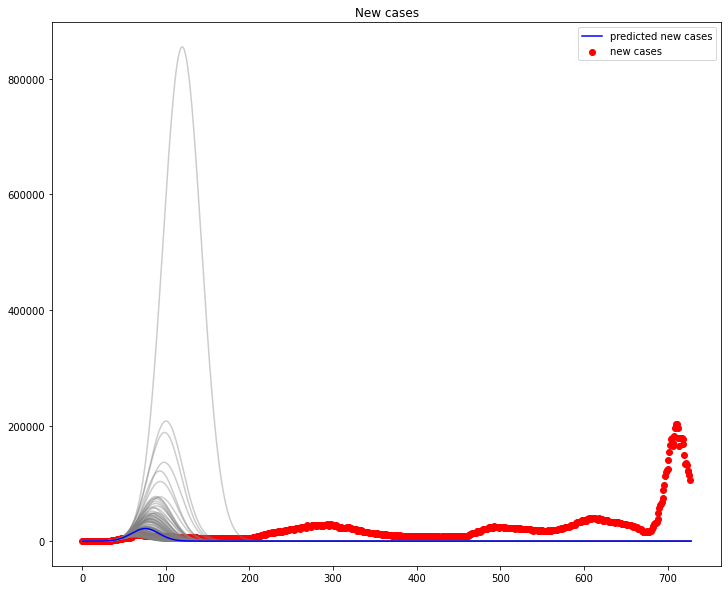

In [411]:
samples = 1000
n = 100
data = df.loc[:800]
x = np.linspace(0, len(data), samples)[:, None]
x_train = np.hstack((x**2, x))
weights = np.random.multivariate_normal(mu, sigma, n)
for a, b, c in weights:
    plt.plot(x.flatten(), np.exp(a * x**2 + b * x + c), color="grey", alpha=.4)
plt.plot(x.flatten(), np.exp(lin_reg2.predict(x_train)), color="b", label="predicted new cases")
plt.scatter(data.index, data.new_cases, color="r", label="new cases")
plt.legend()
plt.title("New cases")
plt.show()

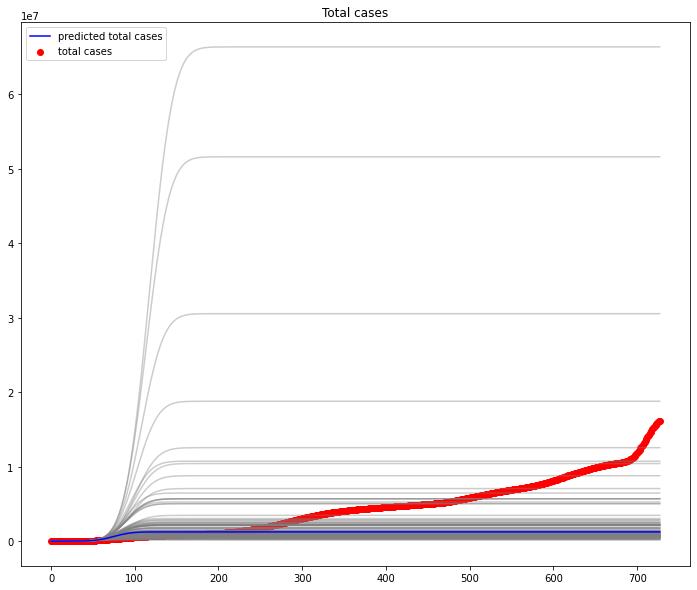

In [429]:
samples = 1000
n = 100
data = df.loc[:800]
x = np.linspace(data.index[0], data.index[-1], samples)[:, None]
x_train = np.hstack((x**2, x))
weights = np.random.multivariate_normal(mu, sigma, n)
sample_preds = []
for a, b, c in weights:
    sample_preds.append(np.cumsum(np.exp(a * x**2 + b * x + c)))
    plt.plot(x.flatten(), sample_preds[-1], color="grey", alpha=.4)
plt.plot(x.flatten(), np.cumsum(np.exp(lin_reg2.predict(x_train))), color="b", label="predicted total cases")
plt.scatter(data.index, data.total_cases, color="r", label="total cases")
plt.legend()
plt.title("Total cases")
plt.show()